In [1]:
# Imports 

import numpy as np
from numpy import *
import scipy
from scipy.special import erf
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from scipy.special import factorial2 as fact2
#import basis_set_exchange as bse
import itertools

In [2]:
class BasisFunction:
    ''' A class that contains all our basis function data
            Attributes:
            origin: array/list containing the coordinates of the Gaussian origin
            shell:  tuple of angular momentum
            exps:   list of primitive Gaussian exponents
            coefs:  list of primitive Gaussian coefficients
            norm:   list of normalization factors for Gaussian primitives
    '''
    def __init__(self,origin=[0.0,0.0,0.0],shell=(0,0,0),exps=[],coefs=[]): 
        self.origin = np.asarray(origin)
        self.shell = shell
        self.exps = exps
        self.coefs = coefs
        self.norm = None
        self.normalize()
        
    def normalize(self):
        ''' Routine to normalize the basis functions, in case they
                    do not integrate to unity.
                '''
        l,m,n = self.shell
        L = l+m+n
        # self.norm is a list of length equal to number primitives 
        # normalize primitives first (PGBFs)
        self.norm = np.sqrt(np.power(2,2*(l+m+n)+1.5)*\
                            np.power(self.exps,l+m+n+1.5)/fact2(2*l-1)/fact2(2*m-1)/fact2(2*n-1)/np.power(np.pi,1.5))
        # now normalize the contracted basis functions (CGBFs) # Eq. 1.44 of Valeev integral whitepaper
        prefactor = np.power(np.pi,1.5)*\
                fact2(2*l - 1)*fact2(2*m - 1)*fact2(2*n - 1)/np.power(2.0,L)
        N = 0.0
        num_exps = len(self.exps) 
        for ia in range(num_exps):
            for ib in range(num_exps):
                N += self.norm[ia]*self.norm[ib]*self.coefs[ia]*self.coefs[ib]/np.power(self.exps[ia] + self.exps[ib],L+1.5)
        N *= prefactor
        N = np.power(N,-0.5)
        for ia in range(num_exps):
            self.coefs[ia] *= N
            
    def basisfcn_matrix(self,xdom,ydom,zdom):
        ''' Method that returns a 3-dimensional matrix corresponding to the 
            3D basis function evaluated in space on over a domain (xdom,ydom,zdom)
        '''
        l,m,n = self.shell
        xi = self.exps  
        G = np.zeros((len(xdom),len(ydom),len(zdom)))
        for i in range(len(xi)):
            gauss_x = xdom**l*np.exp(-xi[i]*xdom**2)
            gauss_y = ydom**m*np.exp(-xi[i]*ydom**2)
            gauss_z = zdom**n*np.exp(-xi[i]*zdom**2)
            Temp = np.kron(gauss_z,np.kron(gauss_y,gauss_x))
            G += self.coefs[i]*np.reshape(Temp,[len(xdom),len(ydom),len(zdom)])
            
        return G
            
            
            

In [3]:
def E(i,j,t,Qx,a,b):
    ''' Recursive definition of Hermite Gaussian coefficients.
            Returns a float.
            a: orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b: orbital exponent on Gaussian 'b' (e.g. beta in the text)
            i,j: orbital angular momentum number on Gaussian 'a' and 'b'
            t: number nodes in Hermite (depends on type of integral,
               e.g. always zero for overlap integrals)
            Qx: distance between origins of Gaussian 'a' and 'b'
    '''
    p=a+b
    q = a*b/p
    if (t < 0) or (t > (i + j)): # out of bounds for t
        return 0.0
    elif i == j == t == 0: # base case
        return np.exp(-q*Qx*Qx) # K_AB 
    elif j == 0: # decrement index i
        return (1/(2*p))*E(i-1,j,t-1,Qx,a,b) -  (q*Qx/a)*E(i-1,j,t,Qx,a,b) +  (t+1)*E(i-1,j,t+1,Qx,a,b)
    else: # decrement index j
        return (1/(2*p))*E(i,j-1,t-1,Qx,a,b) +  (q*Qx/b)*E(i,j-1,t,Qx,a,b) +  (t+1)*E(i,j-1,t+1,Qx,a,b)
            
def overlap(a,lmn1,A,b,lmn2,B):
    ''' Evaluates overlap integral between two Gaussians
            Returns a float.
            a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
            lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                  for Gaussian 'a'
            lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
            A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
            B:    list containing origin of Gaussian 'b'
    '''
    l1,m1,n1 = lmn1 # shell angular momentum on Gaussian 'a' 
    l2,m2,n2 = lmn2 # shell angular momentum on Gaussian 'b' 
    S1 = E(l1,l2,0,A[0]-B[0],a,b) # X
    S2 = E(m1,m2,0,A[1]-B[1],a,b) # Y
    S3 = E(n1,n2,0,A[2]-B[2],a,b) # Z
    return S1*S2*S3*np.power(np.pi/(a+b),1.5)

def kinetic(a,lmn1,A,b,lmn2,B):
    ''' Evaluates kinetic energy integral between two Gaussians
            Returns a float.
            a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
            lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                  for Gaussian 'a'
            lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
            A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
            B:    list containing origin of Gaussian 'b'
    '''
    
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    
    term0 = b*(2*(l2+m2+n2)+3)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2),B)
    
    term1 = -2*np.power(b,2)*(overlap(a,(l1,m1,n1),A,b,(l2+2,m2,n2),B) +
                            overlap(a,(l1,m1,n1),A,b,(l2,m2+2,n2),B) +
                            overlap(a,(l1,m1,n1),A,b,(l2,m2,n2+2),B))
    
    term2 = -0.5*(l2*(l2-1)*overlap(a,(l1,m1,n1),A,b,(l2-2,m2,n2),B) +
                  m2*(m2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2-2,n2),B) +
                  n2*(n2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2-2),B)) 
    
    return term0+term1+term2

def R(t,u,v,n,p,PCx,PCy,PCz,RPC):
    ''' Returns the Coulomb auxiliary Hermite integrals
            Returns a float.
            Arguments:
            t,u,v:   order of Coulomb Hermite derivative in x,y,z
                     (see defs in Helgaker and Taylor)
            n:       order of Boys function
            PCx,y,z: Cartesian vector distance between Gaussian
                     composite center P and nuclear center C
            RPC:     Distance between P and C
    '''
    T = p*RPC*RPC
    val = 0.0
    if t == u == v == 0:
        val += np.power(-2*p,n)*boys(n,T) 
    elif t == u == 0:
        if v > 1:
            val += (v-1)*R(t,u,v-2,n+1,p,PCx,PCy,PCz,RPC)
        val += PCz*R(t,u,v-1,n+1,p,PCx,PCy,PCz,RPC) 
    elif t == 0:
        if u > 1:
            val += (u-1)*R(t,u-2,v,n+1,p,PCx,PCy,PCz,RPC)
        val += PCy*R(t,u-1,v,n+1,p,PCx,PCy,PCz,RPC) 
    else:
        if t > 1:
            val += (t-1)*R(t-2,u,v,n+1,p,PCx,PCy,PCz,RPC)
        val += PCx*R(t-1,u,v,n+1,p,PCx,PCy,PCz,RPC) 
    return val

from scipy.special import hyp1f1
def boys(n,T):
    return hyp1f1(n+0.5,n+1.5,-T)/(2.0*n+1.0)

def gaussian_product_center(a,A,b,B): 
    return (a*A+b*B)/(a+b)

def nuclear_attraction(a,lmn1,A,b,lmn2,B,C):
    ''' Evaluates kinetic energy integral between two Gaussians
             Returns a float.
             a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
             b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
             lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                   for Gaussian 'a'
             lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
             A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
             B:    list containing origin of Gaussian 'b'
             C:    list containing origin of nuclear center 'C'
    '''
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    p=a+b
    P = gaussian_product_center(a,A,b,B) # Gaussian composite center 
    RPC = np.linalg.norm(P-C)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                 val += E(l1,l2,t,A[0]-B[0],a,b) * E(m1,m2,u,A[1]-B[1],a,b) * E(n1,n2,v,A[2]-B[2],a,b) * \
                    R(t,u,v,0,p,P[0]-C[0],P[1]-C[1],P[2]-C[2],RPC)
    val *= 2*np.pi/p 
    return val

def electron_repulsion(a,lmn1,A,b,lmn2,B,c,lmn3,C,d,lmn4,D): 
    ''' Evaluates kinetic energy integral between two Gaussians
         Returns a float.
         a,b,c,d:   orbital exponent on Gaussian 'a','b','c','d'
         lmn1,lmn2
         lmn3,lmn4: int tuple containing orbital angular momentum
                    for Gaussian 'a','b','c','d', respectively
         A,B,C,D:   list containing origin of Gaussian 'a','b','c','d'
    '''
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    l3,m3,n3 = lmn3
    l4,m4,n4 = lmn4
    p = a+b # composite exponent for P (from Gaussians 'a' and 'b') 
    q = c+d # composite exponent for Q (from Gaussians 'c' and 'd') 
    alpha = p*q/(p+q)
    P = gaussian_product_center(a,A,b,B) # A and B composite center 
    Q = gaussian_product_center(c,C,d,D) # C and D composite center 
    RPQ = np.linalg.norm(P-Q)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                for tau in range(l3+l4+1): 
                    for nu in range(m3+m4+1):
                        for phi in range(n3+n4+1):
                            val += E(l1,l2,t,A[0]-B[0],a,b) * \
                                    E(m1,m2,u,A[1]-B[1],a,b) * \
                                    E(n1,n2,v,A[2]-B[2],a,b) * \
                                    E(l3,l4,tau,C[0]-D[0],c,d) * \
                                    E(m3,m4,nu ,C[1]-D[1],c,d) * \
                                    E(n3,n4,phi,C[2]-D[2],c,d) * \
                                    np.power(-1,tau+nu+phi) * \
                                    R(t+tau,u+nu,v+phi,0,\
                                        alpha,P[0]-Q[0],P[1]-Q[1],P[2]-Q[2],RPQ)
    val *= 2*np.power(np.pi,2.5)/(p*q*np.sqrt(p+q)) 
    return val

In [4]:
def S(a,b):
    '''Evaluates overlap between two contracted Gaussians
           Returns float.
           Arguments:
           a: contracted Gaussian 'a', BasisFunction object
           b: contracted Gaussian 'b', BasisFunction object
    '''
    s = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            s += a.norm[ia]*b.norm[ib]*ca*cb*\
                 overlap(a.exps[ia],a.shell,a.origin,
                 b.exps[ib],b.shell,b.origin)
    return s

def T(a,b):
    '''Evaluates kinetic energy between two contracted Gaussians
           Returns float.
           Arguments:
           a: contracted Gaussian 'a', BasisFunction object
           b: contracted Gaussian 'b', BasisFunction object
    '''
    t = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            t += a.norm[ia]*b.norm[ib]*ca*cb*kinetic(a.exps[ia],a.shell,a.origin,b.exps[ib],b.shell,b.origin)
    return t

def V(a,b,C,Z):
    '''Evaluates overlap between two contracted Gaussians
            Returns float.
            Arguments:
            a: contracted Gaussian 'a', BasisFunction object
            b: contracted Gaussian 'b', BasisFunction object
            C: center of nucleus
    '''
    v = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            v += a.norm[ia]*b.norm[ib]*ca*cb*nuclear_attraction(a.exps[ia],a.shell,a.origin,b.exps[ib],b.shell,b.origin,C)
    return -v*Z

def ERI(a,b,c,d):
    '''Evaluates overlap between two contracted Gaussians
            Returns float.
            Arguments:
            a: contracted Gaussian 'a', BasisFunction object
            b: contracted Gaussian 'b', BasisFunction object
            c: contracted Gaussian 'b', BasisFunction object
            d: contracted Gaussian 'b', BasisFunction object
    '''
    eri = 0.0
    for ja, ca in enumerate(a.coefs):
        for jb, cb in enumerate(b.coefs):
            for jc, cc in enumerate(c.coefs):
                for jd, cd in enumerate(d.coefs):
                    eri += a.norm[ja]*b.norm[jb]*c.norm[jc]*d.norm[jd]*\
                           ca*cb*cc*cd*\
                           electron_repulsion(a.exps[ja],a.shell,a.origin,\
                                b.exps[jb],b.shell,b.origin,\
                                c.exps[jc],c.shell,c.origin,\
                                d.exps[jd],d.shell,d.origin)
    return eri

In [5]:
def chemtophys(VVmat):
    n = VVmat.shape[0]
    VVmatph = np.zeros((n,n,n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    VVmatph[i,j,k,l] = VVmat[i,k,j,l]
    return VVmatph

def calcRHFenergy(Hcore,F,P):
    return 0.5*np.einsum('qp,pq',P,Hcore+F)

def density_matrix_diff(Ptilde,P):
    B = P.shape[0]
    x = 0
    for i in range(B):
        for j in range(B):
            x += B**-2*(Ptilde[i,j]-P[i,j])**2
    
    return x**0.5

def calc_nuclear_nuclear(atom_coordinates,Z):
    Vnn = 0.0
    Nat = len(atom_coordinates)
    for i in range(Nat):
        for j in range(Nat):
            if i != j:
                Ri = np.asarray(atom_coordinates[i][:])
                Rj = np.asarray(atom_coordinates[j][:])
                Vnn += Z[i]*Z[j]/np.linalg.norm(Ri-Rj)
    return Vnn/2

def orthomat(S,tol,kind):
    evalS, U = np.linalg.eigh(S)
    diagS_minushalf = np.diag(evalS**(-0.5))
    if kind == 'symmetric':
        X0 = np.dot(U,np.dot(diagS_minushalf,U.T))
    else:
        X0 = np.dot(U,diagS_minushalf)
        
    idX = [i for i in range(S.shape[0])]
    for i in range(S.shape[0]):
        for j in range(i+1,S.shape[0]):
            if np.abs(evalS[i]-evalS[j]) < tol:
                J = idX.index(j)
                idX.remove(J)
    X = X0[:,idX]
    return X

def calc_density_matrix(C_sorted, Nelec):
    Pmat = np.zeros((C_sorted.shape[0],C_sorted.shape[1]))
    for i in range(C_sorted.shape[0]):
        for j in range(C_sorted.shape[0]):
            for a in range(int(Nelec/2)):
                Pmat[i,j] += 2*C_sorted[i,a]*C_sorted[j,a]
    return Pmat

def construct_orbitals(SHELL, XI, CM, atom_coordinates):
    orbs = []; Nat = len(SHELL);
    for i in range(Nat):
        for j in range(len(XI[i])):
            orbs.append(BasisFunction(origin=atom_coordinates[i][:],shell=SHELL[i][j],exps=XI[i][j],coefs=CM[i][j]))
    return orbs

def ao_to_mo(AO,C):
    if len(AO.shape) == 2:
        T1 = np.einsum('jb,ij->ib',C,AO,optimize=True)
        T2 = np.einsum('ia,ib->ab',C,T1,optimize=True)
        return T2
    else:
        T1 = np.einsum('ld,ijkl->ijkd',C,AO,optimize=True)
        T2 = np.einsum('kc,ijkd->ijcd',C,T1,optimize=True)
        T3 = np.einsum('jb,ijcd->ibcd',C,T2,optimize=True)
        T4 = np.einsum('ia,ibcd->abcd',C,T3,optimize=True)
        return T4

def deltafcn(i,j):
    if i == j:
        return 1
    else:
        return 0

def spatial_to_spinorb(MO):
    Norb = MO.shape[0]
    if len(MO.shape) == 2:
        MO_sp = np.zeros((2*Norb,2*Norb))
        for i in range(2*Norb):
            for j in range(2*Norb):
                if i%2 == j%2:    
                    i0 = int(np.floor(i/2))
                    j0 = int(np.floor(j/2))
                    MO_sp[i,j] = MO[i0,j0]
            
    else:
        MO_sp = np.zeros((2*Norb,2*Norb,2*Norb,2*Norb))
        for i in range(2*Norb):
            for j in range(2*Norb):
                for k in range(2*Norb):
                    for l in range(2*Norb):
                        if i%2 == k%2 and j%2 == l%2:
                            i0 = int(np.floor(i/2))
                            j0 = int(np.floor(j/2))
                            k0 = int(np.floor(k/2))
                            l0 = int(np.floor(l/2))
                            MO_sp[i,j,k,l] = MO[i0,j0,k0,l0]
    return MO_sp
                
def diis_pulay_solver(X_list,diis_resid_list):
        B_dim = len(X_list) + 1
        B = np.empty((B_dim, B_dim))
        B[-1, :] = -1
        B[:, -1] = -1
        B[-1, -1] = 0
        for i in range(len(X_list)):
            for j in range(i,len(X_list)):
                B[i, j] = np.einsum('ij,ij->', diis_resid_list[i], diis_resid_list[j], optimize=True)
                B[j, i] = B[i, j]

        # Build RHS of Pulay equation 
        rhs = np.zeros((B_dim))
        rhs[-1] = -1

        # Solve Pulay equation for c_i's 
        if np.linalg.det(B) != 0:
            coeff = np.linalg.solve(B, rhs)
            # Build DIIS Fock matrix 
            X = np.zeros_like(X_list[0])
            for x in range(B_dim - 1):
                X += coeff[x] * X_list[x]
            return X
        else:
            return X[-1]

In [7]:
#### CCSD Functions ####

def cc_energy(t1,t2,VM,FM):
    Ecc = np.einsum('ia,ai->',FM[:Nocc,Nocc:],t1,optimize=True) +\
          0.25*np.einsum('ijab,abij->',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) +\
          0.5*np.einsum('jb,bj->',np.einsum('ijab,ai->jb',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True),t1,optimize=True)
    return Ecc
                
def t1_fcn(t1,t2,VM,FM):
    
    # Fock masks to zero diagonal
    Zocc = np.ones((Nocc,Nocc)) - np.eye(Nocc)
    Zunocc = np.ones((Nunocc,Nunocc)) - np.eye(Nunocc)
    
    # Intermediates
    chi_me = FM[:Nocc,Nocc:] + np.einsum('mnef,fn->me',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_mi = FM[:Nocc,:Nocc]*Zocc + \
             np.einsum('mnif,fn->mi',VM[:Nocc,:Nocc,:Nocc,Nocc:],t1,optimize=True)+ \
             0.5*np.einsum('mnef,efin->mi',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    
    chi_ae = FM[Nocc:,Nocc:]*Zunocc + \
             np.einsum('anef,fn->ae',VM[Nocc:,:Nocc,Nocc:,Nocc:],t1,optimize=True) - \
             0.5*np.einsum('mnef,afmn->ae',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) - \
             np.einsum('me,am->ae',chi_me,t1,optimize=True)
    
    TEMP1 = FM[Nocc:,:Nocc] + \
            np.einsum('me,aeim->ai',chi_me,t2,optimize=True) - \
            np.einsum('maie,em->ai',VM[:Nocc,Nocc:,:Nocc,Nocc:],t1,optimize=True) -\
            np.einsum('mi,am->ai',chi_mi,t1,optimize=True) + \
            np.einsum('ae,ei->ai',chi_ae,t1,optimize=True) - \
            0.5*np.einsum('mnif,afmn->ai',VM[:Nocc,:Nocc,:Nocc,Nocc:],t2,optimize=True) + \
            0.5*np.einsum('anef,efin->ai',VM[Nocc:,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    

    return TEMP1

def t2_fcn(t1,t2,VM,FM):
    
    # Fock masks to zero diagonal
    Zocc = np.ones((Nocc,Nocc)) - np.eye(Nocc)
    Zunocc = np.ones((Nunocc,Nunocc)) - np.eye(Nunocc)
    
    # Intermediates    
    chi_mi = FM[:Nocc,:Nocc]*Zocc + \
             np.einsum('mnif,fn->mi',VM[:Nocc,:Nocc,:Nocc,Nocc:],t1,optimize=True)+ \
             np.einsum('mnef,efin->mi',0.5*VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    
    chi_me = FM[:Nocc,Nocc:] + np.einsum('mnef,fn->me',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_ae = FM[Nocc:,Nocc:]*Zunocc + \
             np.einsum('anef,fn->ae',VM[Nocc:,:Nocc,Nocc:,Nocc:],t1,optimize=True) - \
             0.5*np.einsum('mnef,afmn->ae',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) - \
             np.einsum('me,am->ae',chi_me,t1,optimize=True)
    
    chit_mi = chi_mi + np.einsum('me,ei->mi',chi_me,t1,optimize=True)
    
    chit_anef = VM[Nocc:,:Nocc,Nocc:,Nocc:] - \
                0.5*np.einsum('mnef,am->anef',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_anej = VM[Nocc:,:Nocc,Nocc:,:Nocc] - \
               0.5*np.einsum('mnej,am->anej',VM[:Nocc,:Nocc,Nocc:,:Nocc],t1,optimize=True) + \
               0.5*np.einsum('anef,fj->anej',chit_anef,t1,optimize=True)
    
    chi_mnif = VM[:Nocc,:Nocc,:Nocc,Nocc:] + \
               0.5*np.einsum('mnef,ei->mnif',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_mbij = VM[:Nocc,Nocc:,:Nocc,:Nocc] - \
                0.5*np.einsum('mnij,bn->mbij',VM[:Nocc,:Nocc,:Nocc,:Nocc],t1,optimize=True) - \
                0.5*np.einsum('bmef,efij->mbij',chit_anef,t2,optimize=True)
    
    chi_abej = 0.5*VM[Nocc:,Nocc:,Nocc:,:Nocc] - np.einsum('anej,bn->abej',chi_anej,t1,optimize=True)
    
    chi_mnij = 0.5*VM[:Nocc,:Nocc,:Nocc,:Nocc] + \
               0.25*np.einsum('mnef,efij->mnij',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) + \
               np.einsum('mnif,fj->mnij',chi_mnif,t1,optimize=True)
    
    chi_anef = chit_anef - 0.5*np.einsum('mnef,am->anef',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chit_anej = VM[Nocc:,:Nocc,Nocc:,:Nocc] - \
                np.einsum('mnej,am->anej',VM[:Nocc,:Nocc,Nocc:,:Nocc],t1,optimize=True) - \
                0.5*np.einsum('mnef,afmj->anej',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) +\
                np.einsum('anef,fj->anej',chi_anef,t1,optimize=True)
    
    chi_efij = np.einsum('ei,fj->efij',t1,t1,optimize=True) + 0.5*t2
    
    # standard order
    TEMP2 = np.einsum('abej,ei->abij',chi_abej,t1,optimize=True) - \
            np.einsum('anej,ebin->abij',chit_anej,t2,optimize=True) - \
            0.5*np.einsum('mbij,am->abij',chi_mbij,t1,optimize=True) + \
            0.5*np.einsum('ae,ebij->abij',chi_ae,t2,optimize=True) - \
            0.5*np.einsum('mi,abmj->abij',chit_mi,t2,optimize=True) + \
            0.25*np.einsum('mnij,abmn->abij',chi_mnij,t2,optimize=True) +\
            0.25*np.einsum('abef,efij->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True) 
    # (ij)
    TEMP2_ij = np.einsum('abei,ej->abij',chi_abej,t1,optimize=True) - \
               np.einsum('anei,ebjn->abij',chit_anej,t2,optimize=True) - \
               0.5*np.einsum('mbji,am->abij',chi_mbij,t1,optimize=True) + \
               0.5*np.einsum('ae,ebji->abij',chi_ae,t2,optimize=True) - \
               0.5*np.einsum('mj,abmi->abij',chit_mi,t2,optimize=True) + \
               0.25*np.einsum('mnji,abmn->abij',chi_mnij,t2,optimize=True) +\
               0.25*np.einsum('abef,efji->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True) 
    # (ab)
    TEMP2_ab = np.einsum('baej,ei->abij',chi_abej,t1,optimize=True) - \
               np.einsum('bnej,eain->abij',chit_anej,t2,optimize=True) - \
               0.5*np.einsum('maij,bm->abij',chi_mbij,t1,optimize=True) + \
               0.5*np.einsum('be,eaij->abij',chi_ae,t2,optimize=True) - \
               0.5*np.einsum('mi,bamj->abij',chit_mi,t2,optimize=True) + \
               0.25*np.einsum('mnij,bamn->abij',chi_mnij,t2,optimize=True) +\
               0.25*np.einsum('baef,efij->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True)
    # (ij)(ab)
    TEMP2_abij = np.einsum('baei,ej->abij',chi_abej,t1,optimize=True) - \
                 np.einsum('bnei,eajn->abij',chit_anej,t2,optimize=True) - \
                 0.5*np.einsum('maji,bm->abij',chi_mbij,t1,optimize=True) + \
                 0.5*np.einsum('be,eaji->abij',chi_ae,t2,optimize=True) - \
                 0.5*np.einsum('mj,bami->abij',chit_mi,t2,optimize=True) + \
                 0.25*np.einsum('mnji,bamn->abij',chi_mnij,t2,optimize=True) +\
                 0.25*np.einsum('baef,efji->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True)  
    
    return VM[Nocc:,Nocc:,:Nocc,:Nocc] + TEMP2 - TEMP2_ij - TEMP2_ab + TEMP2_abij

def t1_update(t1,t2,VM,FM,occ,unocc):
    X_ai = t1_fcn(t1,t2,VM,FM)
    for a in range(Nunocc):
        for i in range(Nocc):
            D_ai = FM[occ[i],occ[i]]-FM[unocc[a],unocc[a]]
            t1[a,i] = X_ai[a,i]/D_ai
    return t1

def t2_update(t1,t2,VM,FM,occ,unocc):
    X_abij = t2_fcn(t1,t2,VM,FM)
    for a in range(Nunocc):
        for b in range(a+1,Nunocc):
            for i in range(Nocc):
                for j in range(i+1,Nocc):
                    D2_abij = FM[occ[i],occ[i]]+FM[occ[j],occ[j]]-FM[unocc[a],unocc[a]]-FM[unocc[b],unocc[b]]
                    t2[a,b,i,j] = X_abij[a,b,i,j]/D2_abij
                    t2[b,a,i,j] = -t2[a,b,i,j]
                    t2[a,b,j,i] = -t2[a,b,i,j]
                    t2[b,a,j,i] = t2[a,b,i,j]
    return t2

In [8]:
basis = 'DZP'

# Obtain the basis set in nwchem format (as a string) for hydrogen and carbon
#BS = bse.get_basis(basis, elements=[1], fmt='gamess_us',header=False)
#print(BS)

if basis == '6-31g':
    shell_A = [(0,0,0),(0,0,0)]
    xi_A = [[0.1873113696E+02, 0.2825394365E+01, 0.6401216923E+00 ],[0.1612777588E+00]]
    Cm_A = [[0.3349460434E-01, 0.2347269535E+00, 0.8137573261E+00],[1.0000000]]
    shell_B = [(0,0,0),(0,0,0)]
    xi_B = [[0.1873113696E+02, 0.2825394365E+01, 0.6401216923E+00 ],[0.1612777588E+00]]
    Cm_B = [[0.3349460434E-01, 0.2347269535E+00, 0.8137573261E+00],[1.0000000]]
elif basis == 'sto-6g':
    shell_A = [(0,0,0)]
    xi_A = [[0.3552322122E+02, 0.6513143725E+01, 0.1822142904E+01, 0.6259552659E+00, 0.2430767471E+00, 0.1001124280E+00]]
    Cm_A = [[0.9163596281E-02, 0.4936149294E-01, 0.1685383049E+00, 0.3705627997E+00, 0.4164915298E+00, 0.1303340841E+00]]
    shell_B = [(0,0,0)]
    xi_B = [[0.3552322122E+02, 0.6513143725E+01, 0.1822142904E+01, 0.6259552659E+00, 0.2430767471E+00, 0.1001124280E+00]]
    Cm_B = [[0.9163596281E-02, 0.4936149294E-01, 0.1685383049E+00, 0.3705627997E+00, 0.4164915298E+00, 0.1303340841E+00]]
elif basis == 'DZP':
    shell_A = [(0,0,0),(0,0,0),(1,0,0),(0,1,0),(0,0,1)]
    xi_A = [[19.2406, 2.89920, 0.65340],[0.17760],[1],[1],[1]]
    Cm_A = [[0.032828, 0.231208, 0.817238],[1],[1],[1],[1]]
    shell_B = [(0,0,0),(0,0,0),(1,0,0),(0,1,0),(0,0,1)]
    xi_B = [[19.2406, 2.89920, 0.65340],[0.17760],[1],[1],[1]]
    Cm_B = [[0.032828, 0.231208, 0.817238],[1],[1],[1],[1]]
else:
    shell_A = [(0,0,0)]
    xi_A = [[0.3425250914E+01, 0.6239137298E+00, 0.1688554040E+00]]
    Cm_A = [[0.1543289673E+00, 0.5353281423E+00, 0.4446345422E+00]]
    shell_B = [(0,0,0)]
    xi_B = [[0.3425250914E+01, 0.6239137298E+00, 0.1688554040E+00]]
    Cm_B = [[0.1543289673E+00, 0.5353281423E+00, 0.4446345422E+00]]


SHELL = [shell_A, shell_B]
XI = [xi_A,xi_B]
CM = [Cm_A,Cm_B]

In [ ]:
# Molecule definition

# Number of atoms
Nat = 2
# Atomic valencies
Z = [1, 1]
# Number of electrons
Nelec = 2
# Geometries
RJ = np.linspace(0.5,6,80)

In [9]:
# Calculation setup

# SCF solver parameters
level_shift = 0.0
damp_p = 2/3
maxit_scf = 500
tol_scf = 10**-6
diis_size_scf = 5

# CC Solver parameters
maxit_cc = 100
tol_cc = 10**-6 
diis_size_cc = 8

# Print flag
flag_print = True

In [10]:
# Initialize containers
EHF = np.zeros(len(RJ)); Enuc = np.zeros(len(RJ)); Etot0 = np.zeros(len(RJ)); Etot = np.zeros(len(RJ))
Coeff_list = []; Pmat_list = []; MOeps_list = []; orbs_list = []

# Number of occupied spatial orbitals (RHF, closed shell case)
Nocc0 = int(Nelec/2)

# Coordinate sweep
for J in range(len(RJ)):
    
    ####### Integral Calculation #########

    atom_coordinates = [[0, 0, -RJ[J]/2],
                        [0, 0, RJ[J]/2]]
    
    # Construct atom-centered CGO basis functions
    orbs = []
    for i in range(Nat):
        for j in range(len(XI[i])):
            orbs.append(BasisFunction(origin=atom_coordinates[i][:],shell=SHELL[i][j],exps=XI[i][j],coefs=CM[i][j]))
    Norb = len(orbs)
    
    # Calculate spatial orbital matrices
    Smat = np.zeros((Norb,Norb))
    Tmat = np.zeros((Norb,Norb))
    Vmat = np.zeros((Norb,Norb))
    VVmat = np.zeros((Norb,Norb,Norb,Norb))

    for i in range(Norb):
        for j in range(Norb):
            Smat[i,j] = S(orbs[i],orbs[j])
            Tmat[i,j] = T(orbs[i],orbs[j])
            for k in range(Nat):
                Vmat[i,j] += V(orbs[i],orbs[j],atom_coordinates[k][:],Z[k])
            for l in range(Norb):
                for m in range(Norb):
                    VVmat[i,l,j,m] += ERI(orbs[i],orbs[j],orbs[l],orbs[m]) # physics notation
                    
    ####### SCF Routine #########
    
    # Form Hcore
    Hcore = Tmat + Vmat
    
    # Orthogonalization of basis
    X = orthomat(Smat,0.0,'symmetric')
    
    # Initial guess at P
   # if J < 2:
    P = np.zeros((Norb,Norb))
   # else:
   #     P = (1-damp_p)*P + damp_p*Pmat_list[-2]
    
    # Calculate Fock matrix with guess
    G = np.einsum('prqs,rs->pq',VVmat,P,optimize=True)-\
        0.5*np.einsum('prsq,rs->pq',VVmat,P,optimize=True)
    Fock = Hcore + G + level_shift*(Smat-Smat*P*Smat)
    

    eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
    idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
    C = dot(X,Cp[:,idx])
    P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
    
    F_list = []; resid_F = []
        
    it = 1
    flag_conv_scf = False
    while it < maxit_scf:
        
        # Calculate Fock matrix with guess
        G = np.einsum('prqs,rs->pq',VVmat,P,optimize=True)-\
            0.5*np.einsum('prsq,rs->pq',VVmat,P,optimize=True)
        Fock = Hcore + G + level_shift*(Smat-Smat*P*Smat)
        
        # Build DIIS Residual
        diis_r = X.dot(Fock.dot(P).dot(Smat) - Smat.dot(P).dot(Fock)).dot(X)
        
        if np.mean(diis_r**2)**0.5 <= tol_scf:
            flag_conv_scf = True
            it_scf = it
            break
            
        # Append trial & residual vectors to lists
        # (Note: do NOT use extrapolated matrices in F_list!)
        if len(F_list) == diis_size_scf:
            del F_list[0]
            del resid_F[0]
        F_list.append(Fock)
        resid_F.append(diis_r)
        
        # DIIS extrapolated Fock matrix
        if it >= 2:
            Fock = diis_pulay_solver(F_list, resid_F)
    
        # Compute new orbital guess with DIIS Fock matrix
        eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
        idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
        C = dot(X,Cp[:,idx])
        
        # Compute HF energy and density matrix 
        P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
        it += 1
        
    # Compute new orbital guess with DIIS Fock matrix
    eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
    idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
    C = dot(X,Cp[:,idx])

    # Compute HF energy and density matrix 
    P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
            
    # Store charge density, coefficients, and HF energy for given geometry
    Pmat_list.append(P)
    Coeff_list.append(C)
    MOeps_list.append(eps_mo)
        
    EHF[J] = 0.5*np.einsum('qp,pq->',P,Hcore+Fock,optimize=True)
    Enuc[J] = calc_nuclear_nuclear(atom_coordinates,Z)
    Etot0[J] = EHF[J] + Enuc[J]
    
    ####### CCSD Routine #########

    # Convert AO integrals to MO integrals
    VVmat_mo = ao_to_mo(VVmat,C); 
    Fock_mo = ao_to_mo(Fock,C)
    
    # Convert MO spatial integrals to spinorbital integrals
    VM = spatial_to_spinorb(VVmat_mo)
    FM = spatial_to_spinorb(Fock_mo)

    # Antisymmetrize two-body integral matrix
    VM = VM - np.einsum('pqrs->pqsr',VM) 

    # Occupied and unoccuped indices
    occ = [occ for occ in range(2*Nocc0)]; 
    unocc = [unocc for unocc in range(2*Nocc0,2*Norb)]; 
    Nocc = len(occ)
    Nunocc = len(unocc)

    # Initialize T1 and T2 and DIIS containers
    t1 = np.zeros((Nunocc,Nocc))
    t2 = np.zeros((Nunocc,Nunocc,Nocc,Nocc))
    t1_list = []; t2_list = [];
    t1_resid_list = []; t2_resid_list = [];
    
    # Jacobi/DIIS iterations
    it = 1
    flag_conv_cc = False
    while it < maxit_cc:

        # Store old t1 and t2
        t1_old = t1.copy()
        t2_old = t2.copy()

        # Update t1 and t2 by Jacobi
        t1 = t1_update(t1,t2,VM,FM,occ,unocc)
        t2 = t2_update(t1,t2,VM,FM,occ,unocc)

        # Build DIIS Residual
        diis_r1 = t1 - t1_old
        diis_r2 = np.reshape(t2 - t2_old,(Nunocc**2,Nocc**2))
        
        # Check for exit condition
        if np.mean(diis_r1**2)**0.5 + np.mean(diis_r2**2)**0.5 < tol_cc:
            flag_conv_cc = True
            it_cc = it
            break
            
        # Append trial & residual vectors to lists
        # (Note: Do NOT use extrapolated t1/t2 to build these!)
        if len(t1_list) == diis_size_cc:
            del t1_list[0]
            del t1_resid_list[0]
        if len(t2_list) == diis_size_cc:
            del t2_list[0]
            del t2_resid_list[0]
        t1_list.append(t1)
        t1_resid_list.append(diis_r1)
        t2_list.append(t2)
        t2_resid_list.append(diis_r2)
        
        # DIIS extrapolated T1 and T2
        if it >= 2:
            t1 = diis_pulay_solver(t1_list,t1_resid_list)
            t2 = diis_pulay_solver(t2_list,t2_resid_list)

        it += 1
        
    # Correlation energy
    Ecc = cc_energy(t1,t2,VM,FM)
    
    # Total energy
    Etot[J] = Etot0[J] + Ecc
    
    
    ####### Status Print #########
    if flag_print:
        if flag_conv_scf and flag_conv_cc:
            print('R = {}:\nSCF converged ({} iterations), CCSD converged ({} iterations)'.format(RJ[J], it_scf, it_cc))
            print('Erhf = {}   Eccsd = {}   Ecorr = {}\n'.format(Etot0[J],Etot[J],Ecc))
        elif ~flag_conv_scf and flag_conv_cc:
            print('R = {}: SCF not converged in {} iterations\n'.format(RJ[J], maxit_scf))
        elif flag_conv_scf and ~flag_conv_cc:
            print('R = {}:\nSCF converged ({} iterations), CCSD not converged in {} iterations'.format(RJ[J], it_scf, maxit_cc))
            print('Erhf = {}   Eccsd = N/A\n'.format(Etot0[J]))
        else:
            print('Calculation not converged\n')


R = 0.5:
SCF converged (5 iterations), CCSD converged (17 iterations)
Erhf = -0.4665930622237613   Eccsd = -0.496907752842479   Ecorr = -0.030314690618717728

R = 0.569620253164557:
SCF converged (5 iterations), CCSD converged (17 iterations)
Erhf = -0.6526623305762933   Eccsd = -0.6834854392973233   Ecorr = -0.03082310872103

R = 0.6392405063291139:
SCF converged (5 iterations), CCSD converged (17 iterations)
Erhf = -0.7864218455612382   Eccsd = -0.8177039706149759   Ecorr = -0.03128212505373772

R = 0.7088607594936709:
SCF converged (5 iterations), CCSD converged (17 iterations)
Erhf = -0.8840782021185294   Eccsd = -0.9157686465463787   Ecorr = -0.03169044442784934

R = 0.7784810126582278:
SCF converged (5 iterations), CCSD converged (19 iterations)
Erhf = -0.9560320583144621   Eccsd = -0.9880830774844561   Ecorr = -0.03205101916999399

R = 0.8481012658227848:
SCF converged (5 iterations), CCSD converged (18 iterations)
Erhf = -1.0092373832014334   Eccsd = -1.0416068228548307   Ecorr

R = 3.8417721518987342:
SCF converged (5 iterations), CCSD converged (42 iterations)
Erhf = -0.9063244172899494   Eccsd = -1.0120098297936106   Ecorr = -0.10568541250366133

R = 3.911392405063291:
SCF converged (5 iterations), CCSD converged (41 iterations)
Erhf = -0.9011103393181974   Eccsd = -1.0104028245266352   Ecorr = -0.10929248520843783

R = 3.981012658227848:
SCF converged (5 iterations), CCSD converged (40 iterations)
Erhf = -0.8960215417882678   Eccsd = -1.0089364014682536   Ecorr = -0.11291485967998577

R = 4.050632911392405:
SCF converged (5 iterations), CCSD converged (42 iterations)
Erhf = -0.8910560833675827   Eccsd = -1.0076004639486384   Ecorr = -0.11654438058105568

R = 4.120253164556962:
SCF converged (5 iterations), CCSD converged (45 iterations)
Erhf = -0.886211978659217   Eccsd = -1.0063860397730764   Ecorr = -0.12017406111385939

R = 4.189873417721518:
SCF converged (5 iterations), CCSD converged (48 iterations)
Erhf = -0.8814872176995155   Eccsd = -1.00528211605

The bond length is 1.4050632911392404 bohr
The bond energy is -1.1656923254215883 Ha


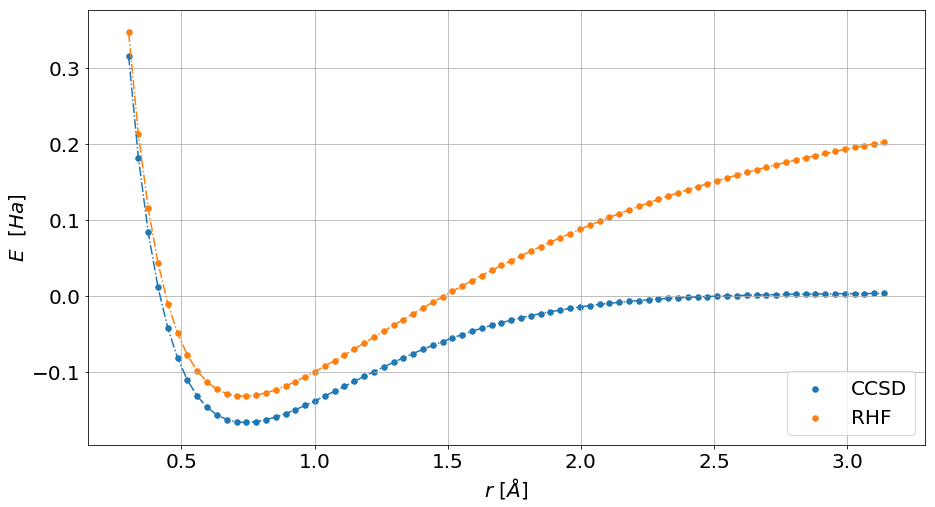

In [20]:
# energy of single H atom (-13.5 eV = 1 Ryd = 0.5 Ha)
E0 = -0.49973349442
bohrtoang = 0.529177
mm = 1

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize = (15,8))
plt.plot(RJ[mm:J]*bohrtoang,Etot[mm:J]-2*E0,'-.')
plt.scatter(RJ[mm:J]*bohrtoang,Etot[mm:J]-2*E0,30,label='CCSD')
plt.plot(RJ[mm:J]*bohrtoang,Etot0[mm:J]-2*E0,'-.')
plt.scatter(RJ[mm:J]*bohrtoang,Etot0[mm:J]-2*E0,30,label='RHF')
plt.grid(True)
plt.xlabel(r'$r$ $[\AA]$')
plt.ylabel(r'$E$  $[Ha]$')
plt.legend(loc=4,fontsize=20)

iconv = np.logical_not(np.isnan(Etot))
Econv = Etot[iconv]
RJconv = RJ[iconv]
Ieq = np.argmin(Econv)
Req = RJconv[Ieq]
Eeq = Econv[Ieq]

print('The bond length is {} bohr'.format(Req))
print('The bond energy is {} Ha'.format(Eeq))